In [1]:
import os
import sys
from optparse import OptionParser

import numpy as np
import scipy as ci 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

%matplotlib inline 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables 
import pickle
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('once')

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/'

<font color ='green'><font size = 6> preliminary distribution

In [12]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 

    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:] * lifetime/n_file


with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2813559.84254, 2955469.73138, 3052686.52963, 3240653.63454, 2919677.64478]  # _gaps.txt; 2012, 2013, 2014, 2015, 2016
    
    zenith_reco_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    truncated_muon_e_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_reco_data_burn))

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: The following kwargs were not used by contour: 'lw'


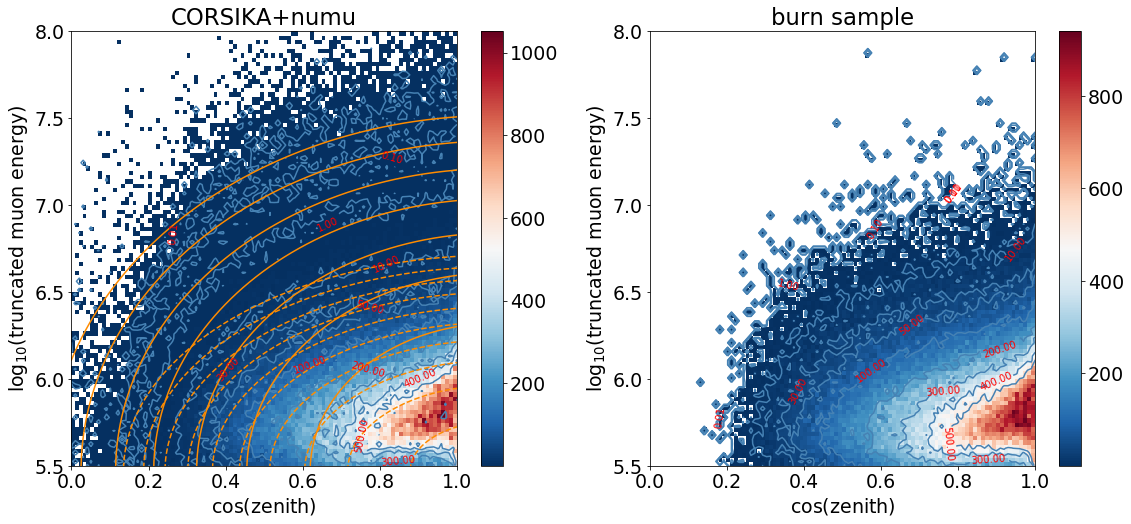

In [13]:
# ----- transform phase space ----- 
plt.rcParams.update({'font.size': 19})
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(19,8))
plt.subplot(121)
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

# near region 
p1 = 5.47 # y center
p2 = 0.9
p3 = 1.1 # x center
p4 = 0.7

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.1,2,0.2)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'--',color='darkorange')

# far region 
p1 = 5.47 # y center
p2 = 1.2
p3 = 1.1 # x center
p4 = 0.68

t = np.arange(0,1,0.0001)
for i, c in enumerate(np.arange(0.5,3,0.4)):
    plt.plot(t, p1 + p2*np.sqrt(c - ((t - p3)/p4)**2  ),'-',color='darkorange')

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,1000],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.title('CORSIKA+numu')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.savefig(fig_dir + 'rf_contour_uncut.png',dpi=600)

plt.subplot(122)
# data
plt.rcParams.update({'font.size': 19})
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

h_,yy_,xx_,img_ = plt.hist2d(np.cos(zenith_reco_data_burn), np.log10(truncated_muon_e_data_burn),cmap=my_cmap,
    bins=100,range=[[0,1],[5.5,8]],weights=weight_data_burn,vmin = 0.001)
plt.colorbar()

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.1,1,10,30,50,100,200,300,400,500,1000],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.title('burn sample')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
# plt.savefig(fig_dir + 'rf_contour_uncut.png',dpi=600)

plt.show()

<font color ='darkorange'><font size = 6> 1) Ineff < 0.01

In [5]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:

    chi2_red_data_burn = (f.root.Collection.cols.chi2[:]/f.root.Collection.cols.NDF[:])
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:]      
    truncated_muon_e_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]
    zenith_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:]
    closest_d_data_burn = f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:]
    passed_2 = (f.root.IT_veto_flag_window_2.cols.value[:]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: The following kwargs were not used by contour: 'lw'
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


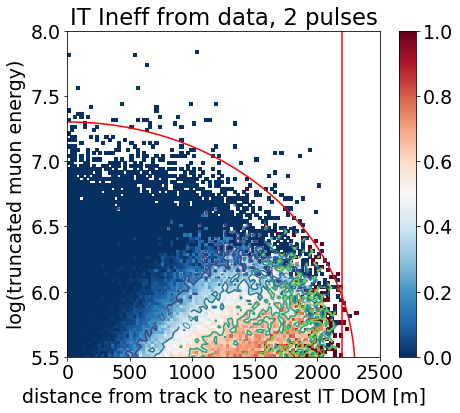

In [6]:
" ----- IT ineff from data -----"
n_ = 100
emax = 8
e_spacing = (emax-5.5)/n_
d_spacing = (2500)/n_

Dist = []
Energy = []
Ineff_2 = []

for energy in np.linspace(5.5,emax,n_): # in each energy range [e1,e2]
    for dist in np.linspace(0,2500,n_): # in each dist range
        # energy cut  

        CUT_energy = (truncated_muon_e_data_burn>10**energy)&(truncated_muon_e_data_burn<10**(energy+e_spacing))
        CUT_dist = (closest_d_data_burn>dist)&(closest_d_data_burn<(dist+d_spacing))
        CUT = CUT_energy & CUT_dist

        closest_d_binned = closest_d_data_burn[CUT]
        passed_2_binned = passed_2[CUT] # events that pass the veto (not rejected)
        total_events_in_Bin = len(closest_d_binned[:]) # total events in this current bin

        Ineff_2 = np.append(Ineff_2, np.sum(passed_2_binned)/total_events_in_Bin ) # fraction of events pass veto in this distance bin

        Dist = np.append(Dist, dist)
        Energy = np.append(Energy,energy)

plt.figure(figsize=(7,6))
h,yy,xx,img=plt.hist2d(Dist,Energy,bins=[n_,n_],weights=Ineff_2,cmap=my_cmap,vmin=0.0) # ,range=[[0,2500],[5.5,emax]],range=[[0,2500],[5.5,emax]],bins=[n_,n_],
plt.colorbar()
CS=plt.contour(h.transpose(),extent=[0,2500,5.5,emax],lw=1,levels=[0.2,0.4,0.6,0.8])
plt.clabel(CS,inline=1,fmt='%1.1f',fontsize=10)
plt.clim(0,1)

# -- ineff low stat cut --
t = np.arange(0,2500,1)
plt.plot(t, 5.4+1.9*np.sqrt(1 - (t)**2/2300**2),color='r')
plt.axvline(2200,color='r')
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,2500)
plt.ylim(5.5,emax)
plt.title('IT Ineff from data, 2 pulses')
plt.show()

In [7]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2 
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 0.001] = 0.001 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.5
    val[dist>2200]=0.5
    return val

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


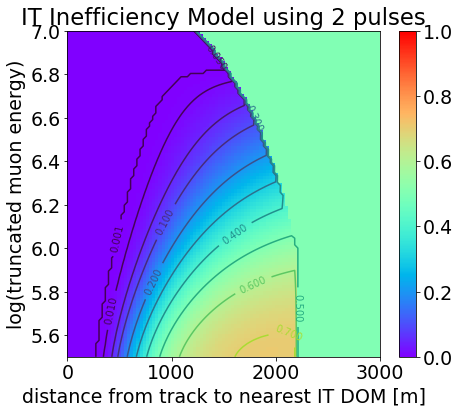

In [8]:
xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model(xg,yg)

plt.figure(figsize=(7,6))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance from track to nearest IT DOM [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('IT Inefficiency Model using 2 pulses')
plt.show()

In [9]:
IT_ineff_cut = 0.01
E_min = 6.0
E_max = 6.2

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r') as f:
    n_file = 72701 # with _rf, the size of broken file is 266K instead of 0! 
    
    ineff_corsika = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_corsika < IT_ineff_cut
    print(np.sum(CUT_ineff)/len(CUT_ineff))

    CUT_phase = (np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])-0.95)**2/0.03**2+\
                (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    
    CUT_truncated_bin = (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])<E_max)
    CUT_zenith = np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])>0.95
    CUT = CUT_ineff & CUT_phase & CUT_truncated_bin & CUT_zenith
#     CUT = CUT_ineff

    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    ndf_corsika = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_corsika = chi2_corsika/ndf_corsika
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_corsika = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]

    ineff_corsika = ineff_corsika[CUT]
    dist_corsika = f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:][CUT]
    weight_corsika = f.root.Weight_GaisserH4a.cols.value[:][CUT] * lifetime/n_file # MODIFIED! 
    print(np.sum(weight_corsika))

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 18989

    ineff_numu = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_numu < IT_ineff_cut
    CUT_phase = (np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])-0.95)**2/0.03**2+\
                (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT = CUT_ineff & CUT_phase
#     CUT = CUT_ineff

    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    ndf_numu = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_numu = chi2_numu/ndf_numu    
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    zenith_reco_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    signal_dnn_numu = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    ineff_numu = ineff_numu[CUT]

    ### astrophysical ###
    energy = f.root.MCPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2813559.84254, 2955469.73138, 3052686.52963, 3240653.63454, 2919677.64478]  # _gaps.txt; 2012, 2013, 2014, 2015, 2016
    

    ineff_data_burn = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data_burn < IT_ineff_cut
    print(np.sum(CUT_ineff)/len(CUT_ineff))
    CUT_phase = (np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])-0.95)**2/0.03**2+\
                (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    
    CUT_truncated_bin = (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])>E_min) & (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])<E_max)
    CUT_zenith = np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])>0.5

    CUT = CUT_ineff & CUT_phase & CUT_truncated_bin & CUT_zenith
    
    
    chi2_data_burn = f.root.Collection.cols.chi2[:][CUT]
    ndf_data_burn = f.root.Collection.cols.NDF[:][CUT]
    chi2_red_data_burn = chi2_data_burn/ndf_data_burn
    
    zenith_reco_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_reco_data_burn))
    print('data,total',np.sum(weight_data_burn))
    CUT_tag = (1-f.root.IT_veto_flag_window_2.cols.value[:][CUT]).astype(bool)
    CUT_untag = (f.root.IT_veto_flag_window_2.cols.value[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    
    chi2_red_data_burn_tag = chi2_red_data_burn[CUT_tag]
    chi2_red_data_burn_untag = chi2_red_data_burn[CUT_untag]

    casllh_tag = f.root.CascadeLlhVertexFitParams.cols.logL[:][CUT][CUT_tag]
    casllh_untag = f.root.CascadeLlhVertexFitParams.cols.logL[:][CUT][CUT_untag]
    
    len_dedx_tag = f.root.Collection.cols.dEdxVector_len[:][CUT][CUT_tag]
    len_dedx_untag = f.root.Collection.cols.dEdxVector_len[:][CUT][CUT_untag]
    
    weight_data_burn_tag = weight_data_burn[CUT_tag] / np.sum(weight_data_burn[CUT_tag]) * np.sum(weight_data_burn)
    weight_data_burn_untag = weight_data_burn[CUT_untag] / np.sum(weight_data_burn[CUT_untag]) * np.sum(weight_data_burn)
    print('N data,tagged',np.sum(CUT_tag))
    print('N data,no tag',np.sum(CUT_untag))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


0.37774569385963264
17324.481589957413
0.40231447381409796
data,total 44100.16328979415
N data,tagged 20903
N data,no tag 48


In [2]:
f1 = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11057.h5','r')
f2 = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r')
f3 = tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r')

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


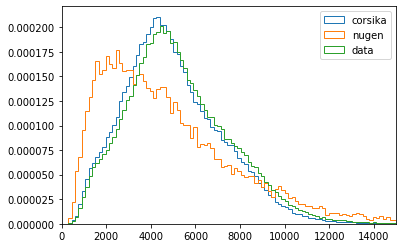

In [6]:
plt.hist(f1.root.CascadeLlhVertexFitParams.cols.logL[:],weights=f1.root.Weight_GaisserH4a.cols.value[:],bins=np.linspace(0,15000,100),normed=1,histtype='step',label='corsika')
plt.hist(f2.root.CascadeLlhVertexFitParams.cols.logL[:],bins=np.linspace(0,15000,100),normed=1,histtype='step',label='nugen')
plt.hist(f3.root.CascadeLlhVertexFitParams.cols.logL[:],bins=np.linspace(0,15000,100),normed=1,histtype='step',label='data')
plt.legend()
# plt.hist(f.root.Collection.cols.dEdxVector_len[:])
plt.xlim(0,15000)
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


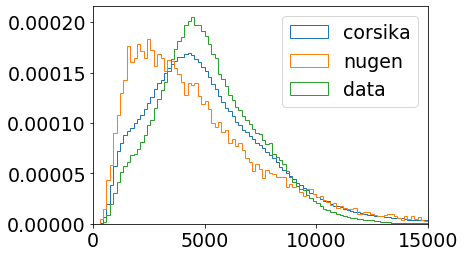

In [46]:
################## plots from a long time ago. Try compare. ##################
plt.hist(f1.root.CascadeLlhVertexFitParams.cols.logL[:],bins=np.linspace(0,15000,100),normed=1,histtype='step',label='corsika')
plt.hist(f2.root.CascadeLlhVertexFitParams.cols.logL[:],bins=np.linspace(0,15000,100),normed=1,histtype='step',label='nugen')
plt.hist(f3.root.CascadeLlhVertexFitParams.cols.logL[:],bins=np.linspace(0,15000,100),normed=1,histtype='step',label='data')
plt.legend()
# plt.hist(f.root.Collection.cols.dEdxVector_len[:])
plt.xlim(0,15000)
plt.show()

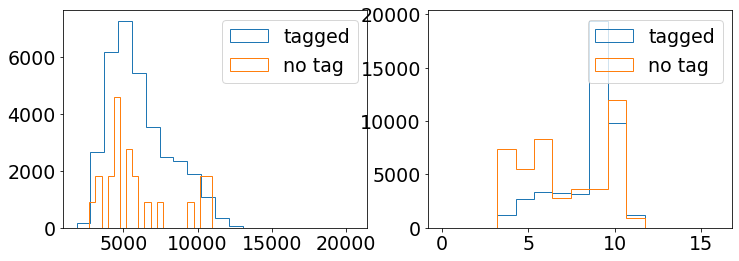

In [50]:
# plt.hist(f.root.CascadeLlhVertexFitParams.cols.rlogL[:],bins=20,histtype='step',log=True)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(casllh_tag[len_dedx_tag>7],histtype='step',bins=20,label='tagged',weights=weight_data_burn_tag[len_dedx_tag>7])
plt.hist(casllh_untag[len_dedx_untag>7],histtype='step',bins=20,label='no tag',weights=weight_data_burn_untag[len_dedx_untag>7])
plt.legend()
plt.subplot(122)
plt.hist(len_dedx_tag,histtype='step',bins=np.linspace(0,16,16),label='tagged',weights=weight_data_burn_tag)
plt.hist(len_dedx_untag,histtype='step',bins=np.linspace(0,16,16),label='no tag',weights=weight_data_burn_untag)
plt.legend()
plt.show()

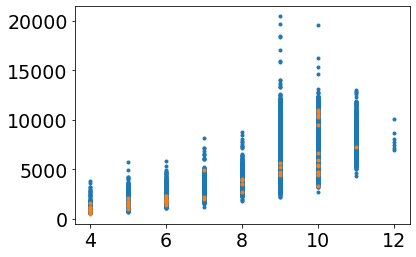

In [13]:
plt.plot(len_dedx_tag,casllh_tag,'.',label='tag')
plt.plot(len_dedx_untag,casllh_untag,'.',label='untag')
plt.show()

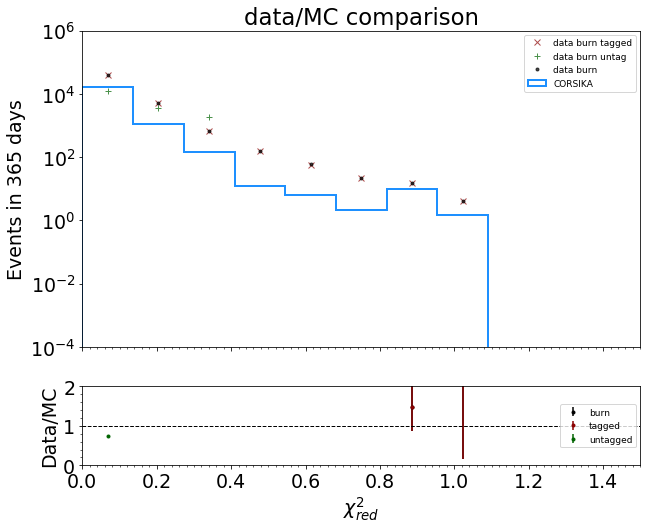

In [14]:
plt.rcParams.update({'font.size': 19})
plt.figure(figsize=(10,8))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

h,b,p = plt.hist(chi2_red_corsika,bins=np.linspace(0,1.5,12),log=True,histtype='step',lw=2,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')

hh_t,bb_t = np.histogram(chi2_red_data_burn_tag,bins=np.linspace(0,1.5,12),weights = weight_data_burn_tag)
plt.plot((bb_t[1:]+bb_t[:-1])/2,hh_t,'x',ms=6,alpha=0.7,label='data burn tagged',color='darkred')
hh_ut,bb_ut = np.histogram(chi2_red_data_burn_untag[(casllh_untag>4000)&(len_dedx_untag>6)],bins=np.linspace(0,1.5,12),weights = weight_data_burn_untag[(casllh_untag>4000)&(len_dedx_untag>6)])
plt.plot((bb_ut[1:]+bb_ut[:-1])/2,hh_ut,'+',ms=6,alpha=0.7,label='data burn untag',color='darkgreen')
hh,bb = np.histogram(chi2_red_data_burn,bins=np.linspace(0,1.5,12),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=6,alpha=0.7,label='data burn',color='black')

plt.ylabel('Events in 365 days')
plt.xlim(0,1.5)
plt.ylim(10**(-4),10**6)
plt.legend(loc='best',prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])

# error of x/y:  x = hh, y = h. x/y*sqrt(1/x+1/y). Only keep terms with value > 0. 
h_t = h[hh_t > 0.]
bb_t = ((bb_t[1:]+bb_t[:-1])/2)[hh_t > 0.]
hh_t = hh_t[hh_t > 0.]
yerr_t = hh_t/h_t * np.sqrt( 1/hh_t + 1/h_t )

h_ut = h[hh_ut > 0.]
bb_ut = ((bb_ut[1:]+bb_ut[:-1])/2)[hh_ut > 0.]
hh_ut = hh_ut[hh_ut > 0.]
yerr_ut = hh_ut/h_ut * np.sqrt( 1/hh_ut + 1/h_ut )

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
hh = hh[hh > 0.]
yerr = hh/h * np.sqrt( 1/hh + 1/h )

plt.errorbar(bb, hh/h, yerr = yerr, fmt='.',ms=6,color='black',label='burn')
plt.errorbar(bb_t, hh_t/h_t, yerr = yerr_t, fmt='.',ms=6,color='darkred',label='tagged')
plt.errorbar(bb_ut, hh_ut/h_ut, yerr = yerr_ut, fmt='.',ms=6,color='darkgreen',label='untagged')


plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('Data/MC')
plt.legend(loc='right',prop={'size': 9})
plt.xlim(0,1.5)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.show()


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


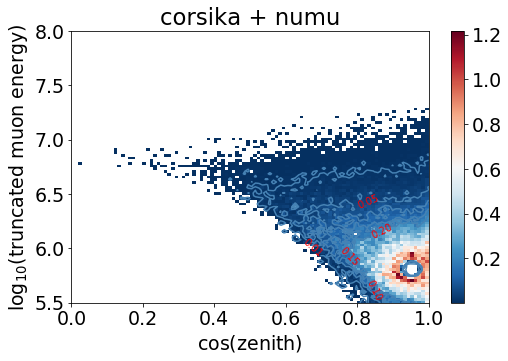

In [10]:
# ----- transform phase space ----- 
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(8,5))
h_,yy_,xx_,img_=plt.hist2d(np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu))),
            np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu))),cmap=my_cmap,
            bins=100,range=[[0,1],[5.5,8]],weights=np.concatenate((weight_corsika,weight_numu_astro)),vmin = 0.001)
plt.colorbar()

CS=plt.contour(h_.transpose(),extent=[0,1,5.5,8],lw=1,levels=[0.01,0.05,0.1,0.15,0.2],colors='steelblue')
plt.clabel(CS,inline=1,fmt='%1.2f',fontsize=10,colors='red')
plt.xlabel(r'$\cos$(zenith)')
plt.ylabel(r'$\log_{10}$(truncated muon energy)')
plt.title('corsika + numu')
# plt.savefig(fig_dir + 'rf_contour_small_ineff.pdf',bbox_inches='tight')
# plt.savefig(fig_dir + 'rf_contour_small_ineff.png',dpi=300,bbox_inches='tight')
plt.show()

In [11]:
pcut1 = 5.82 # y center
pcut2 = 0.08
pcut3 = 0.95 # x center
pcut4 = 0.03

In [12]:
X = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu),8  ))
y = np.zeros((  len(chi2_red_corsika)+len(chi2_red_numu)  ))

X[:,0] = np.concatenate((chi2_red_corsika,chi2_red_numu))
X[:,1] = np.concatenate((np.log10(PeakOverMedian_corsika),np.log10(PeakOverMedian_numu))) 
X[:,2] = np.concatenate((np.cos(zenith_reco_corsika),np.cos(zenith_reco_numu)))
X[:,3] = np.concatenate((np.log10(truncated_muon_e_corsika),np.log10(truncated_muon_e_numu)))
X[:,4] = np.concatenate(( (np.log10(truncated_muon_e_corsika)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_corsika)-pcut3)**2/pcut4**2,
                          (np.log10(truncated_muon_e_numu)-pcut1)**2/pcut2**2+(np.cos(zenith_reco_numu)-pcut3)**2/pcut4**2  ))

X[:,5] = np.concatenate((signal_dnn_corsika,signal_dnn_numu))
X[:,6] = np.concatenate((ineff_corsika,ineff_numu))

X[:,-1] = np.concatenate((weight_corsika,weight_numu_astro)) # weights. should be removed 

y = np.concatenate((np.zeros_like(chi2_red_corsika),np.ones_like(chi2_red_numu)))

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5,random_state=1)
weights_train = X_train[:,-1] * 2
weights_test = X_test[:,-1] * 2
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# create classifier
clf = RandomForestClassifier(n_estimators=500,n_jobs=8)

clf.fit(X_train, y_train)
# _ = joblib.dump(clf, '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/small_ineff_region.pkl', compress = 9)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


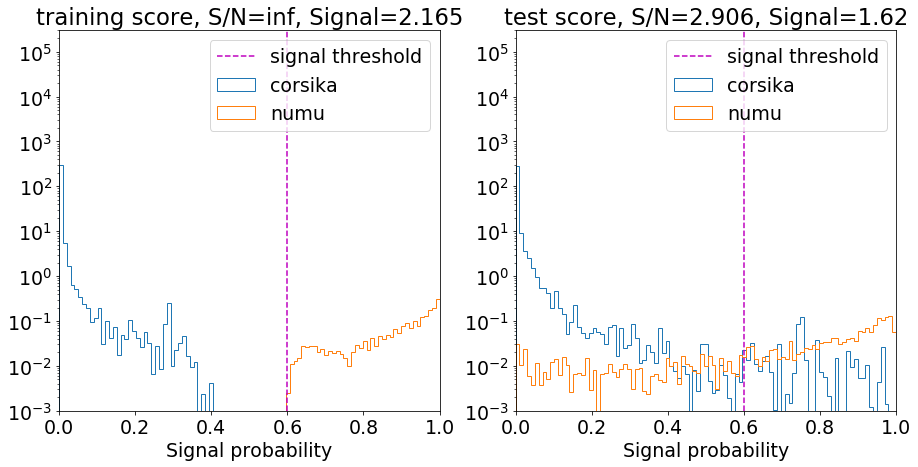

In [16]:
# training set! 
threshold = 0.6
probability_train = clf.predict_proba(X_train)[:,1]
S_N = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] ) / np.sum( (weights_train[y_train==0])[(probability_train[y_train==0])>threshold] )
Sig = np.sum( (weights_train[y_train==1])[(probability_train[y_train==1])>threshold] )

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_train[y_train==0],weights=weights_train[y_train==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_train[y_train==1],weights=weights_train[y_train==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('training score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()

# test set! 
probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score, S/N='+str(np.round(S_N,3))+', Signal='+str(np.round(Sig,3)))
plt.legend()
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

In [17]:
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2813559.84254, 2955469.73138, 3052686.52963, 3240653.63454, 2919677.64478]  # _gaps.txt; 2012, 2013, 2014, 2015, 2016

    ineff_data = ineff_model(f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:],np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:]))
    CUT_ineff = ineff_data < IT_ineff_cut
    CUT_veto = (f.root.IT_veto_flag_window_2.cols.value[:]).astype(bool) # data passed veto 
    CUT_phase = (np.cos(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:])-0.95)**2/0.03**2+\
                (np.log10(f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:])-5.82)**2/0.08**2 > 1
    CUT = CUT_ineff & CUT_veto & CUT_phase
    
    chi2_red_data_burn = (f.root.Collection.cols.chi2[:][CUT]/f.root.Collection.cols.NDF[:][CUT])
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]      
    truncated_muon_e_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.energy[:][CUT]
    zenith_data_burn = f.root.SPEFit4TruncatedEnergy_SPICEMie_DOMS_Muon.cols.zenith[:][CUT]
    closest_d_data_burn = f.root.IT_veto_closest_approach_dist_to_nearest_dom_muon.cols.value[:][CUT]
    signal_dnn_data_burn = f.root.DeepLearningReco_nersc_gnn_weighted_02.cols.is_signal[:][CUT]
    passed_2 = (f.root.IT_veto_flag_window_2.cols.value[:][CUT]).astype(bool) # events that pass the veto (not rejected). NOTE: Need to convert to BOOL type!! 
    ineff_data = ineff_data[CUT]
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(chi2_red_data_burn))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [18]:
# rf classification for untagged data 

X = np.zeros((  len(chi2_red_data_burn),7 ))

X[:,0] = chi2_red_data_burn
X[:,1] = np.log10(PeakOverMedian_data_burn)
X[:,2] = np.cos(zenith_data_burn)
X[:,3] = np.log10(truncated_muon_e_data_burn)
X[:,4] = (np.log10(truncated_muon_e_data_burn)-pcut1)**2/pcut2**2+(np.cos(zenith_data_burn)-pcut3)**2/pcut4**2
X[:,5] = signal_dnn_data_burn
X[:,6] = ineff_data

probability_data = clf.predict_proba(X)[:,1]

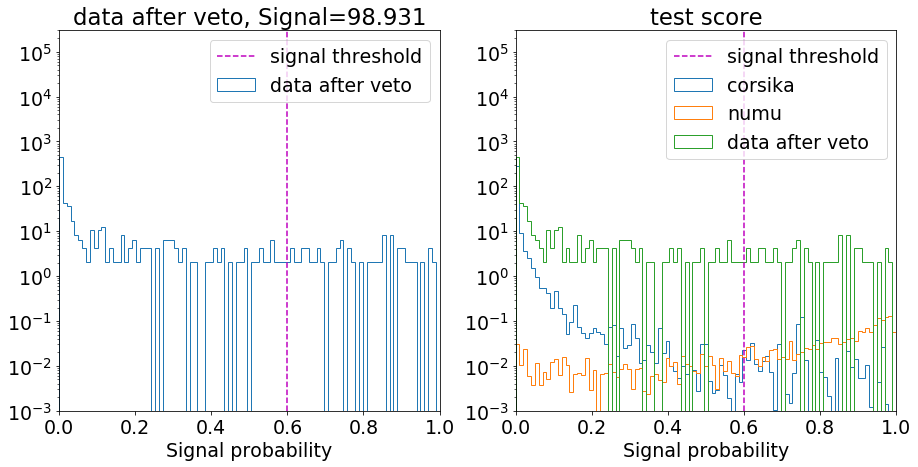

In [19]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,1,100),histtype='step',label='data after veto',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('data after veto, Signal='+str(np.round(np.sum(weight_data_burn[probability_data>0.6]),3)))
plt.legend()
plt.savefig(fig_dir + 'rf_apply_rf_to_data.pdf')


probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,1,100),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,1,100),histtype='step',label='numu',log=True,bottom=10**(-6))
h,b,p=plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,1,100),histtype='step',label='data after veto',log=True,bottom=10**(-6))
# plt.plot(b[1:],h,'.',color='black')
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score')
plt.legend()
plt.xlabel('Signal probability')
# plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
# plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()

In [20]:
# ------ background evaluation ------ # 

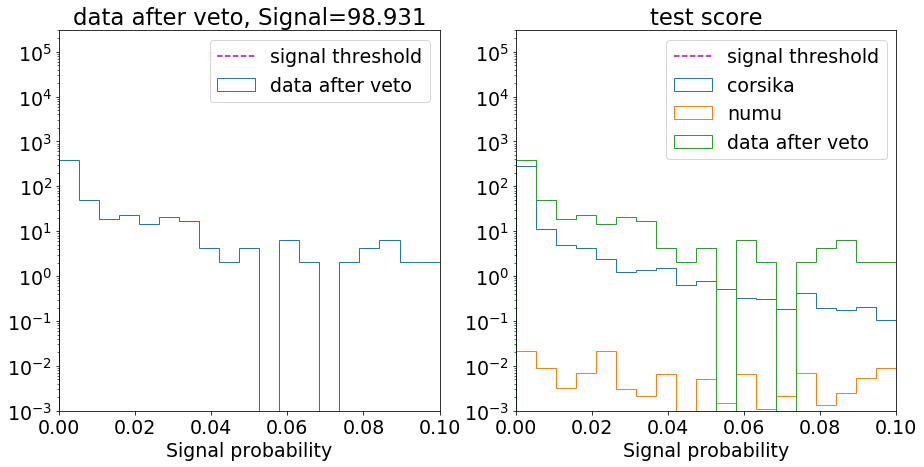

In [21]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,0.1,20),histtype='step',label='data after veto',log=True,bottom=10**(-6))
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,0.1)
plt.ylim(10**(-3),3*10**(5))
plt.xlabel('Signal probability')
plt.title('data after veto, Signal='+str(np.round(np.sum(weight_data_burn[probability_data>0.6]),3)))
plt.legend()
plt.savefig(fig_dir + 'rf_apply_rf_to_data.pdf')


probability_test = clf.predict_proba(X_test)[:,1]
S_N = np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) / np.sum( (weights_test[y_test==0])[(probability_test[y_test==0])>threshold] )
Sig =  np.sum( (weights_test[y_test==1])[(probability_test[y_test==1])>threshold] ) 

plt.subplot(122)
plt.hist(probability_test[y_test==0],weights=weights_test[y_test==0],bins=np.linspace(0,0.1,20),histtype='step',label='corsika',log=True,bottom=10**(-6))
plt.hist(probability_test[y_test==1],weights=weights_test[y_test==1],bins=np.linspace(0,0.1,20),histtype='step',label='numu',log=True,bottom=10**(-6))
h,b,p=plt.hist(probability_data,weights=weight_data_burn,bins=np.linspace(0,0.1,20),histtype='step',label='data after veto',log=True,bottom=10**(-6))
# plt.plot(b[1:],h,'.',color='black')
plt.axvline(threshold,ls='--',color='m',label='signal threshold')
plt.xlim(0,0.1)
plt.ylim(10**(-3),3*10**(5))
plt.title('test score')
plt.legend()
plt.xlabel('Signal probability')
plt.savefig(fig_dir + 'rf_score_small_ineff.pdf')
plt.savefig(fig_dir + 'rf_score_small_ineff.png',dpi=600)
plt.show()